In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

sys.path.append(os.path.abspath('..'))
from utils.utils_constants import (VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH as  VESSEL_PAT_INFO_W_SCORE_W_FEATURE_PATH,
                                   DISEASE_TYPES, ARTERY_TYPES,
)

SEVERITY_MAPPING = {
    '0:absent': 0,
    '1:mild (1-25%)': 1,
    '2:moderate (26-50%)': 2,
    '3:severe (>50%)': 3
}

DEMOGRAPHICS = ['PAT_Sex', 'PAT_Race', 'PAT_Hispanic', 'PAT_AgeV3']
CLININCAL_DATA = ['PAT_Cohort', 'eGFRatBx', 'UPCRatBx']
DESCRIPTOR = ['ArterioSclerosis', "ArterialHyalinosis"]

In [2]:
# suffix = "_measurements_exclude_hya_manual_lumen_convex"
suffix = "_measurements"

In [3]:
def binary_map(x, positive_value):
    return 1 if x == positive_value else 0

In [4]:
agg_feature_path = VESSEL_PAT_INFO_W_SCORE_W_FEATURE_PATH.replace(".csv", f"{suffix}.csv")
pat_df = pd.read_csv(agg_feature_path)

# Applying the function to various columns
pat_df['PAT_Hispanic'] = pat_df['PAT_Hispanic'].apply(lambda x: binary_map(x, '1: Hispanic or Latino'))
pat_df['PAT_Race'] = pat_df['PAT_Race'].apply(lambda x: binary_map(x, '3: Black/African American'))
pat_df['PAT_Sex'] = pat_df['PAT_Sex'].apply(lambda x: binary_map(x, '2: Female'))
pat_df['PAT_Cohort'] = pat_df['PAT_Cohort'].apply(lambda x: binary_map(x, '2 - MCD'))
pat_df['Immunosupression_30dBfOrAtBx'] = pat_df['Immunosupression_30dBfOrAtBx'].apply(lambda x: binary_map(x, '1: Yes'))

pat_df['ArterioSclerosis'] = pat_df['ArterioSclerosis'].map(SEVERITY_MAPPING)
pat_df['ArterialHyalinosis'] = pat_df['ArterialHyalinosis'].map(SEVERITY_MAPPING)

covariates_to_normalize = ['PAT_AgeV3', 'eGFRatBx', 'UPCRatBx', 'ArterioSclerosis', 'ArterialHyalinosis']  # add numerical columns here
scaler = StandardScaler() # choose a scaler?
pat_df[covariates_to_normalize] = scaler.fit_transform(pat_df[covariates_to_normalize]) # in place
pat_df['DaysBXtoESRDorEGFR40_LR'] = pd.to_numeric(pat_df['DaysBXtoESRDorEGFR40_LR'], errors='coerce')
pat_df['ESRDorEGFR40BX_LR'] = pat_df['ESRDorEGFR40BX_LR'].map({'1: Yes': 1, '0: No': 0}).astype(int)

In [11]:
feature_names = ['Intima Area Ratio', 'Media Area Ratio', 
                #  'Intima Average', 'Intima Peak Height', 
                #  'Media Average', 'Media Peak Height', 
                #  'Ratio Average', 'Ratio Peak Height'
                 ]
agged_features_by_type = {}
agged_scores_by_type = {}

for artery_type in ARTERY_TYPES:
    agged_features = []
    for feature_name in feature_names:
        for agg_metric in ["Median", "75th", "25th"]:
            agged_feature = '_'.join([agg_metric, feature_name, "in", artery_type])
            agged_features.append(agged_feature.replace(" ", "_"))
    agged_features_by_type[artery_type] = agged_features

    score_features = []
    for disease in DISEASE_TYPES:
        for agg_metric in ["Max", "Median", "75th"]:
            score_feature= '_'.join([agg_metric, disease, "Severity", "in", artery_type])
            score_features.append(score_feature.replace(" ", "_"))
    agged_scores_by_type[artery_type] = score_features
    


In [12]:
def survival_analysis(pat_df_selected, feature_name, percentile, ax, c=""):
    # Determine the specified percentile value of the feature
    threshold = pat_df_selected[feature_name].quantile(percentile)

    # Create a new column for group based on whether the feature value is above the specified percentile
    if percentile == .5:
        pat_df_selected['Group'] = np.where(pat_df_selected[feature_name] > threshold, f'Above Median', f'Below or Equal Median')
    else:
        pat_df_selected['Group'] = np.where(pat_df_selected[feature_name] > threshold, f'Above {percentile*100}th', f'Below or Equal {percentile*100}th')

    # Prepare data for log-rank test
    durations = []
    events = []
    labels = []
    assert(len(pat_df_selected['Group'].unique()) == 2)
    for group in sorted(pat_df_selected['Group'].unique()):
        df_sub = pat_df_selected[pat_df_selected['Group'] == group]
        T = df_sub["DaysBXtoESRDorEGFR40_LR"]
        E = df_sub["ESRDorEGFR40BX_LR"]
        durations.append(T)
        events.append(E)
        labels.append(group)

        if len(T) > 0:  # Ensure there is data to fit
            km = KaplanMeierFitter()
            km.fit(durations=T, event_observed=E, label=group)
            km.plot_survival_function(ax=ax, show_censors=True)

    result = logrank_test(durations[0], durations[1], event_observed_A=events[0], event_observed_B=events[1])
    p_str = "p<0.05" if result.p_value < 0.05 else f"p={result.p_value:.3f}"

    ax.set_xlabel('Days from Biopsy to ESRD or EGFR < 40', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.legend()
    ax.set_title(f"({c}){feature_name}: \n log rank test: {p_str}", fontsize=12, y=-0.25, pad=-5)


def cox_model_analysis(df, base, features, uni=False):
    # Create a figure and axis object with proper dimensions
    # Initialize and fit the Cox proportional hazards model
    if len(features) > 0:
        cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
        cph.fit(df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula="+".join(features))
        summary = cph.summary
        # Compute the absolute values of the coefficients and sort them
        summary['abs_coef'] = summary['coef'].abs()
        summary_sorted = summary.sort_values(by='abs_coef', ascending=False)
        selected_features = summary_sorted[summary_sorted["abs_coef"] > 0.1].index.values.tolist()
        if uni:
            fig, axs = plt.subplots(1, len(selected_features), figsize=(5*len(selected_features), 5))  
            for i, feature_name in enumerate(selected_features):
                survival_analysis(df, feature_name, .75, axs[i], c="") 
            plt.tight_layout()
            plt.show()
    else:
        selected_features = features
    _, ax = plt.subplots(figsize=(10, 8))  # Use subplots instead of figure

    cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
    cph.fit(df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula="+".join(base + selected_features))
    # Plotting the hazard ratios for each feature
    cph.plot(ax=ax)
    # Setting the title with the concordance index
    ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
    plt.show()  # Ensure the plot is displayed

In [13]:
for f in agged_features_by_type["Arcuate Arteries"]:
    if f not in pat_df.columns:
        print(f)
  

(71, 357)


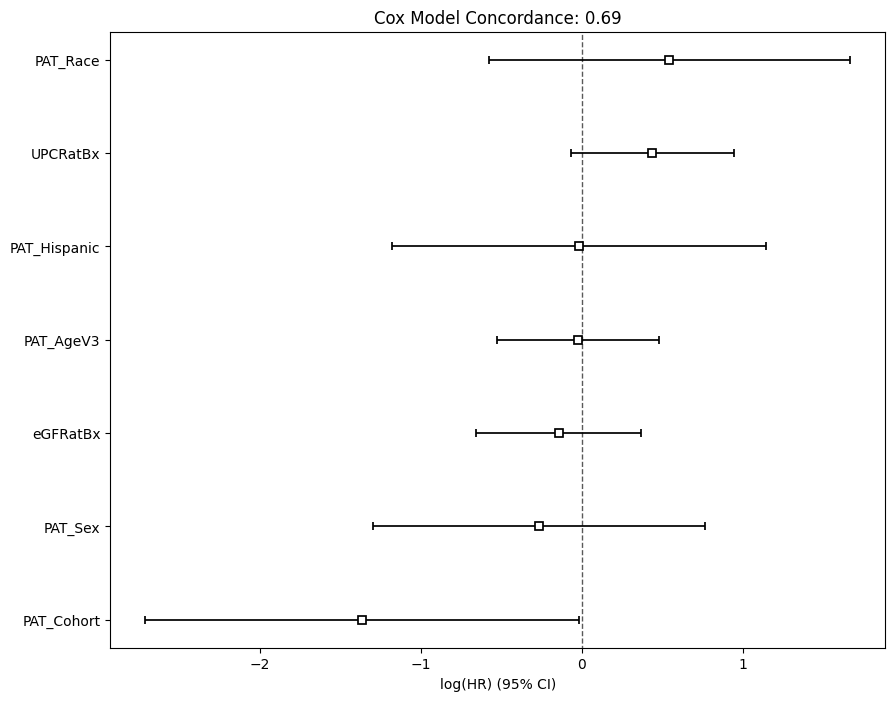

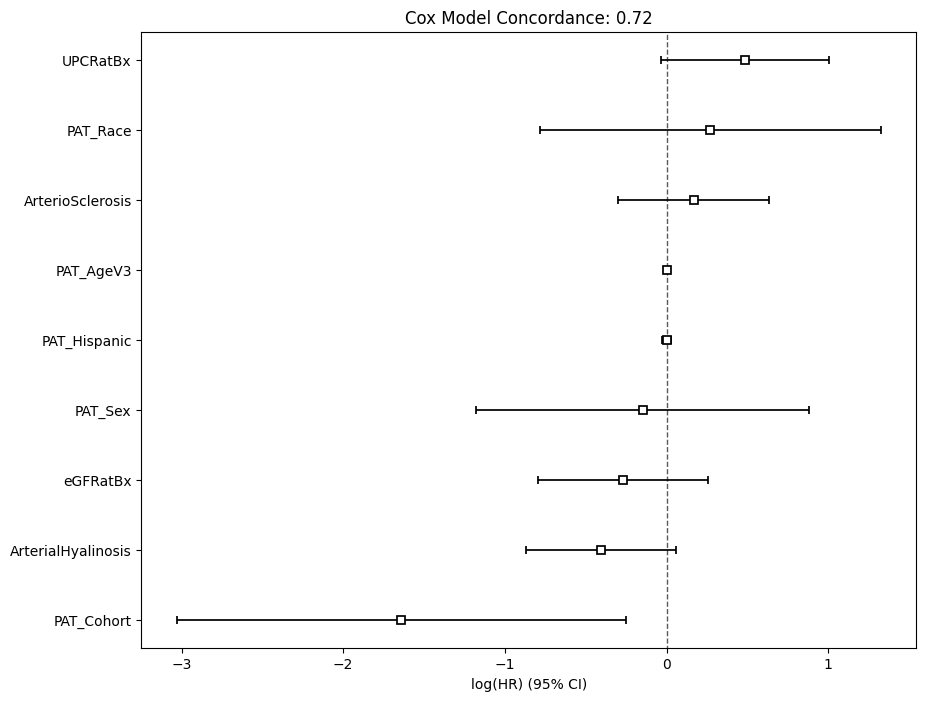

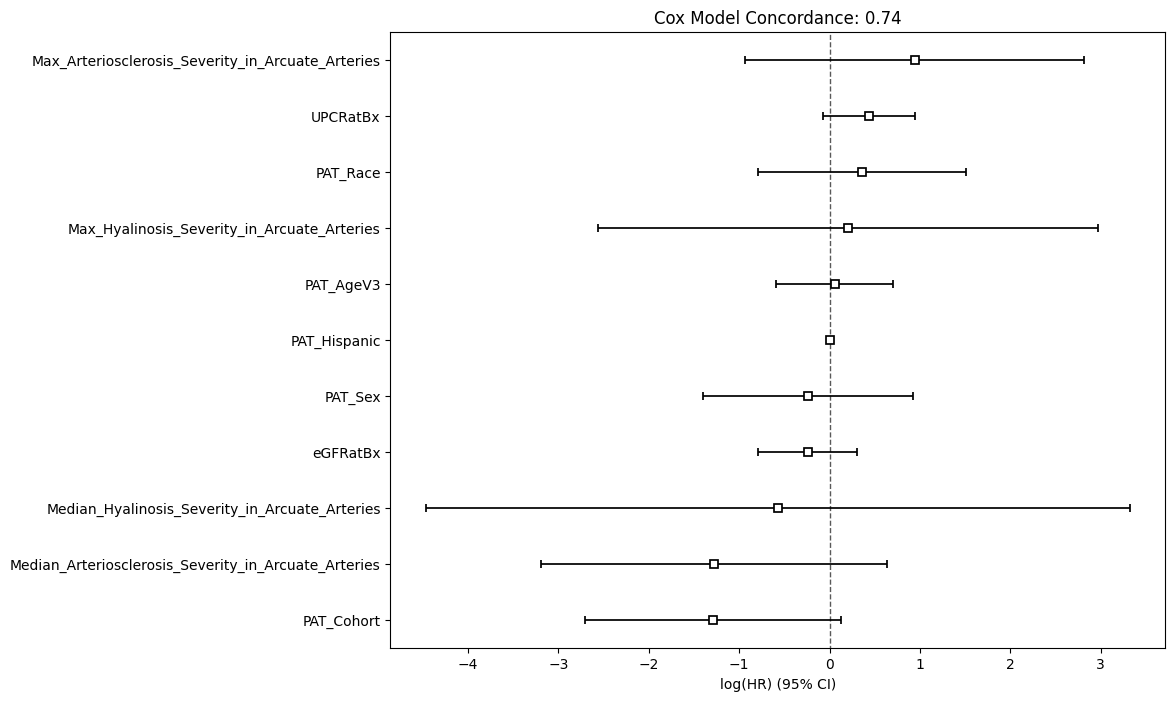

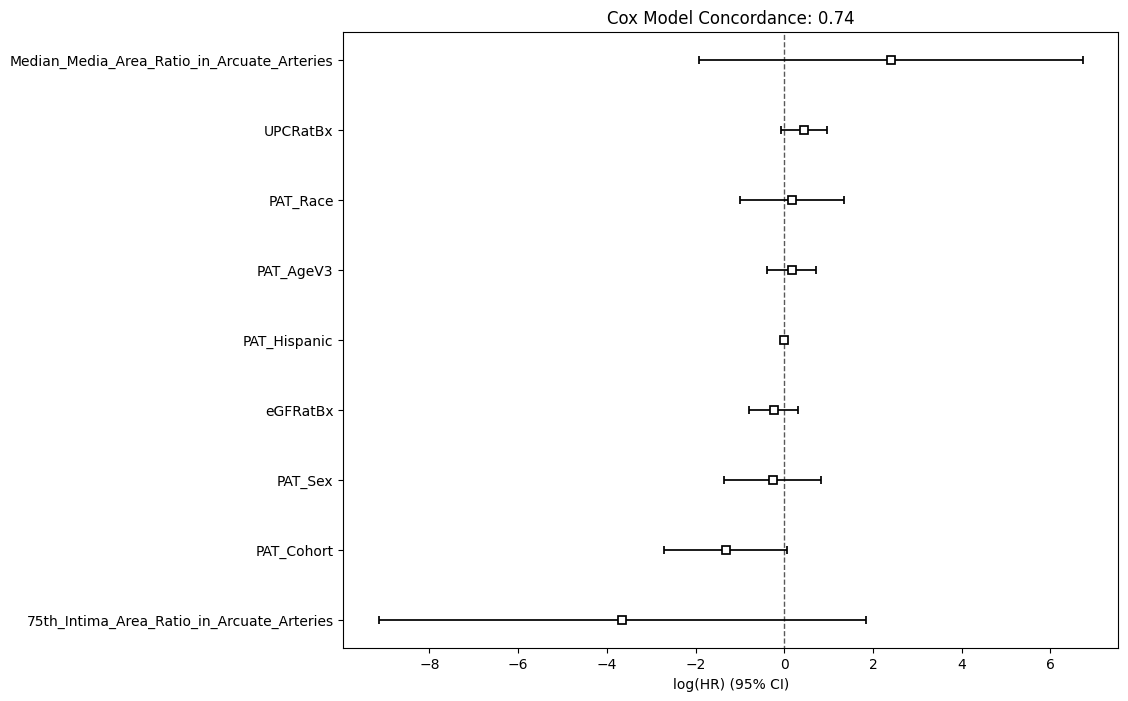

In [14]:
agged_features = agged_features_by_type["Arcuate Arteries"]
score_features = agged_scores_by_type["Arcuate Arteries"]
pat_df_selected = pat_df.dropna(subset = DEMOGRAPHICS + CLININCAL_DATA  + DESCRIPTOR + 
                                score_features + agged_features, inplace = False)
print(pat_df_selected.shape)
# for feature in agged_features:
#     fig, axs = plt.subplots(1, 1, figsize=(8, 5))
#     survival_analysis(pat_df_selected, feature, .5, axs, c="") 
#     plt.tight_layout()
#     plt.show()
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , [])
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , DESCRIPTOR)
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , score_features)
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , agged_features)
# cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , score_features + agged_features)

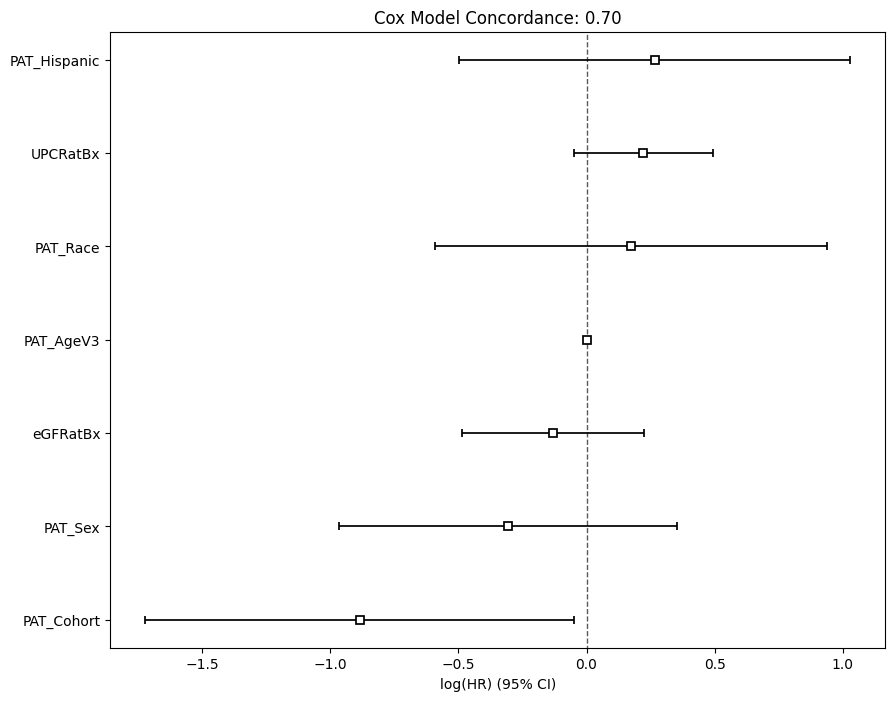

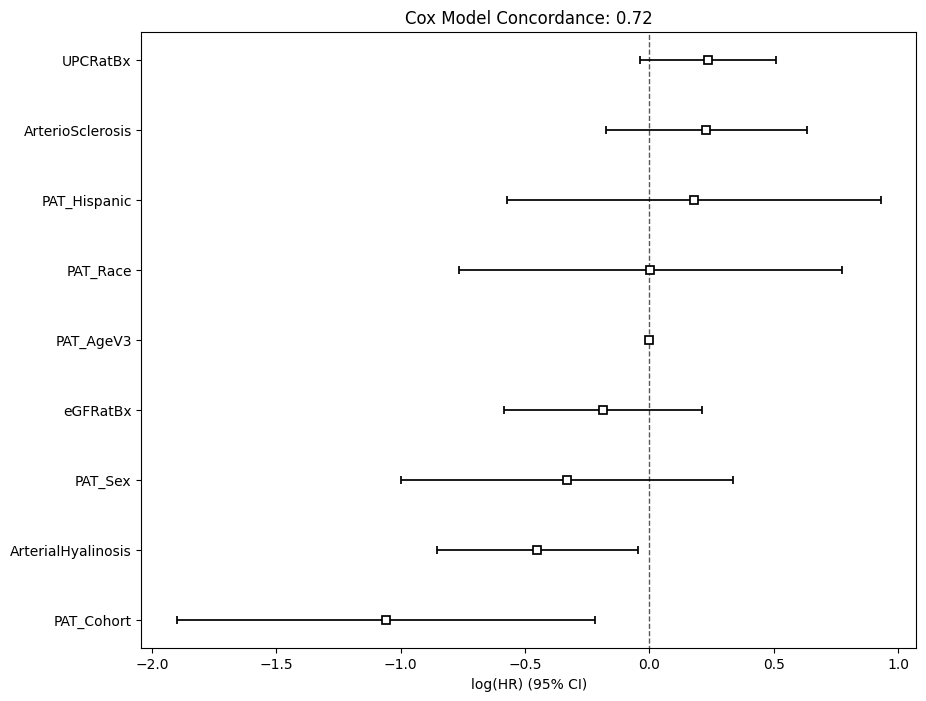

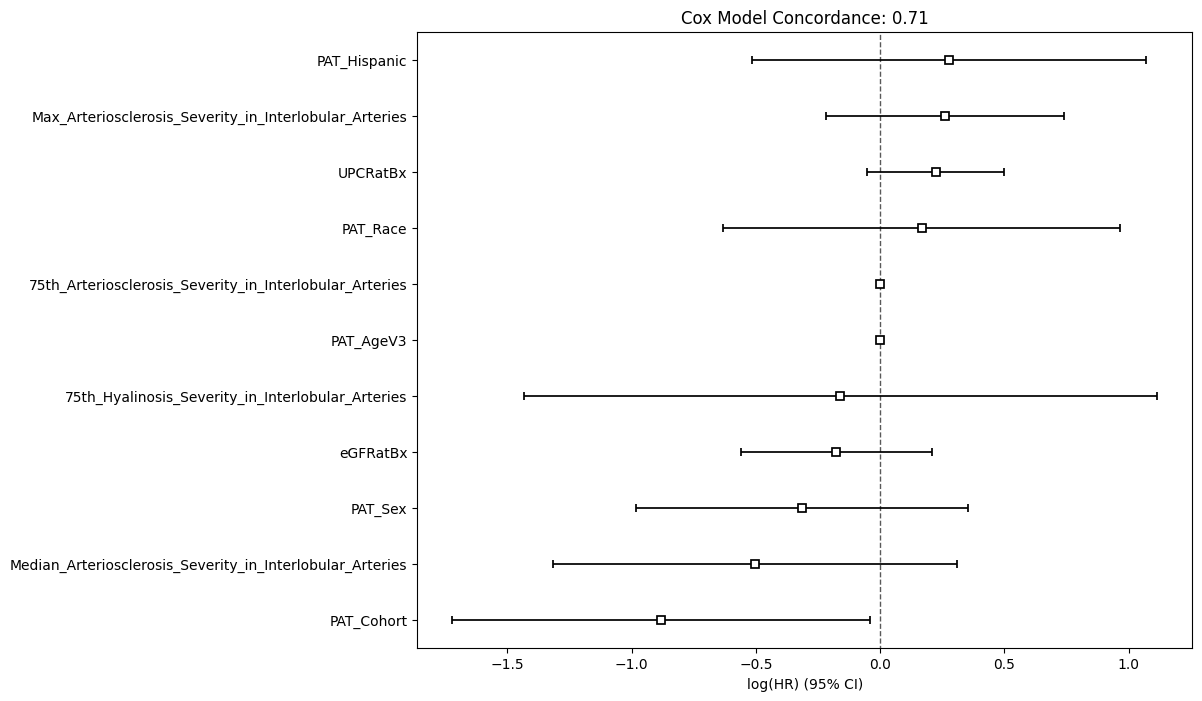

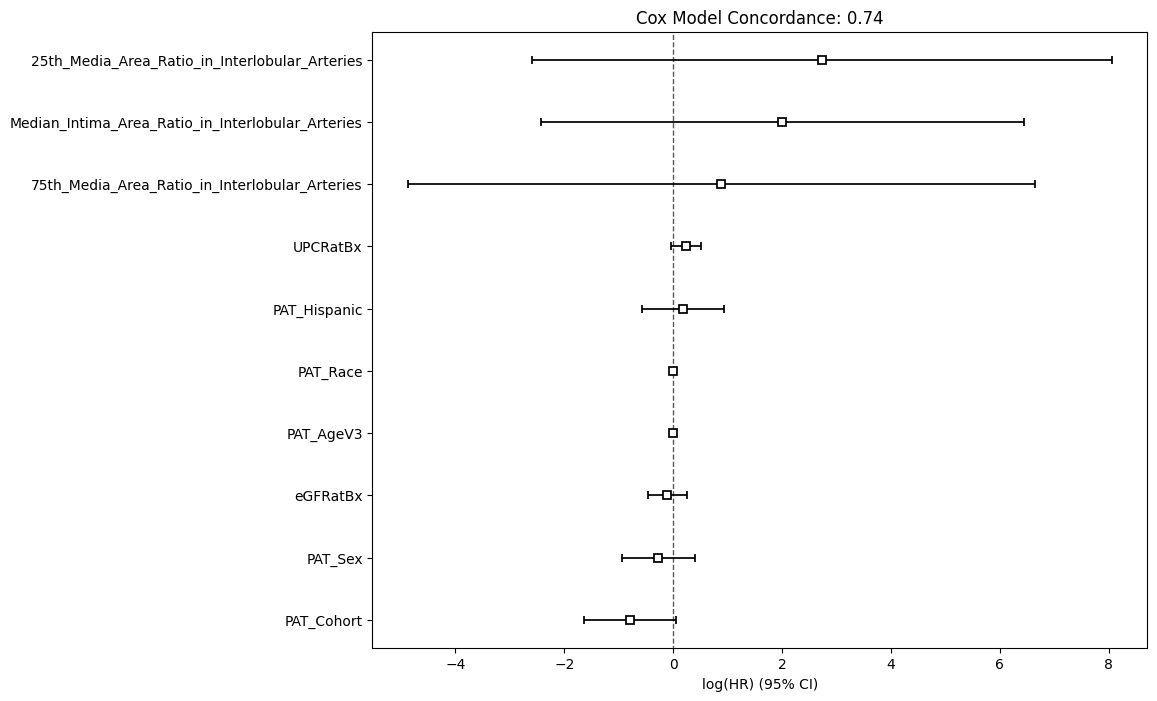

In [15]:
agged_features = agged_features_by_type["Interlobular Arteries"]
score_features = agged_scores_by_type["Interlobular Arteries"]

pat_df_selected = pat_df.dropna(subset = DEMOGRAPHICS + CLININCAL_DATA + DESCRIPTOR + agged_features, inplace = False)
# print(pat_df_selected.shape)
# for feature in agged_features:
#     fig, axs = plt.subplots(1, 1, figsize=(8, 5))
#     survival_analysis(pat_df_selected, feature, .5, axs, c="") 
#     plt.tight_layout()
#     plt.show()
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , [])
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , DESCRIPTOR)
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , score_features)
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , agged_features)

# cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , score_features + agged_features)

(192, 357)


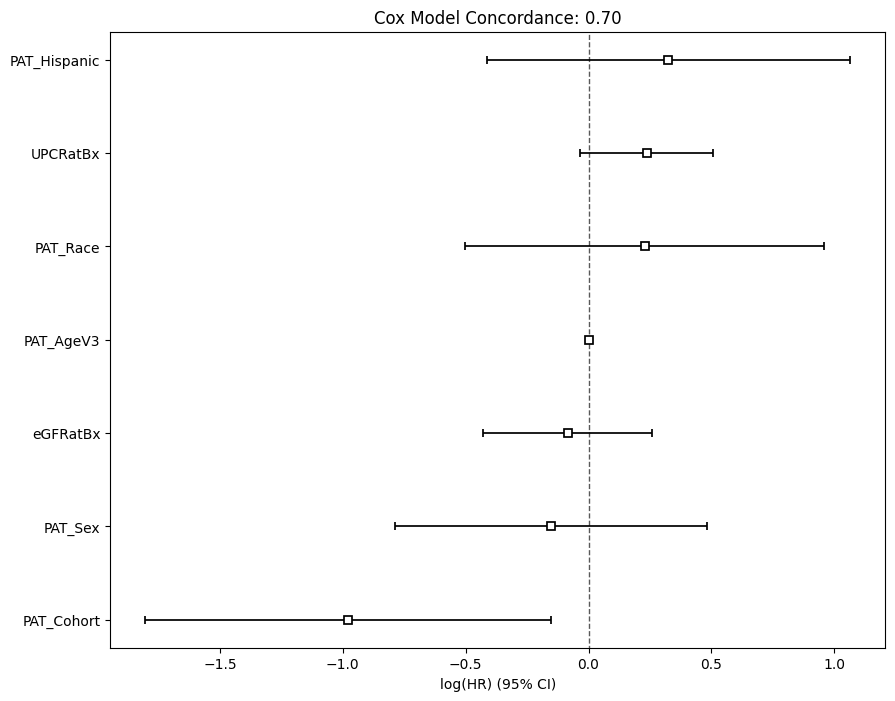

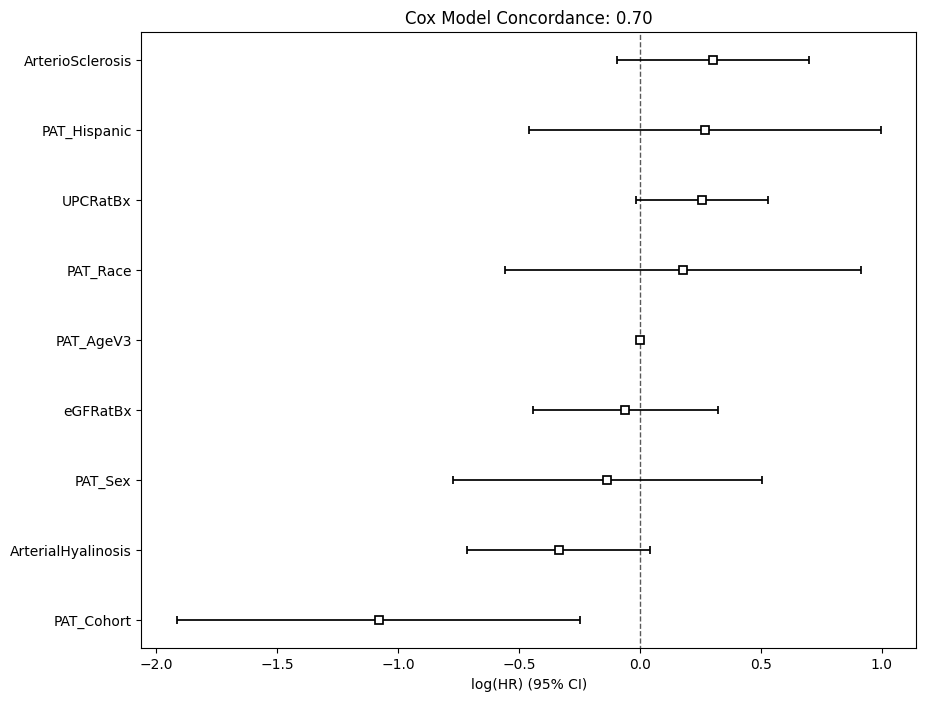

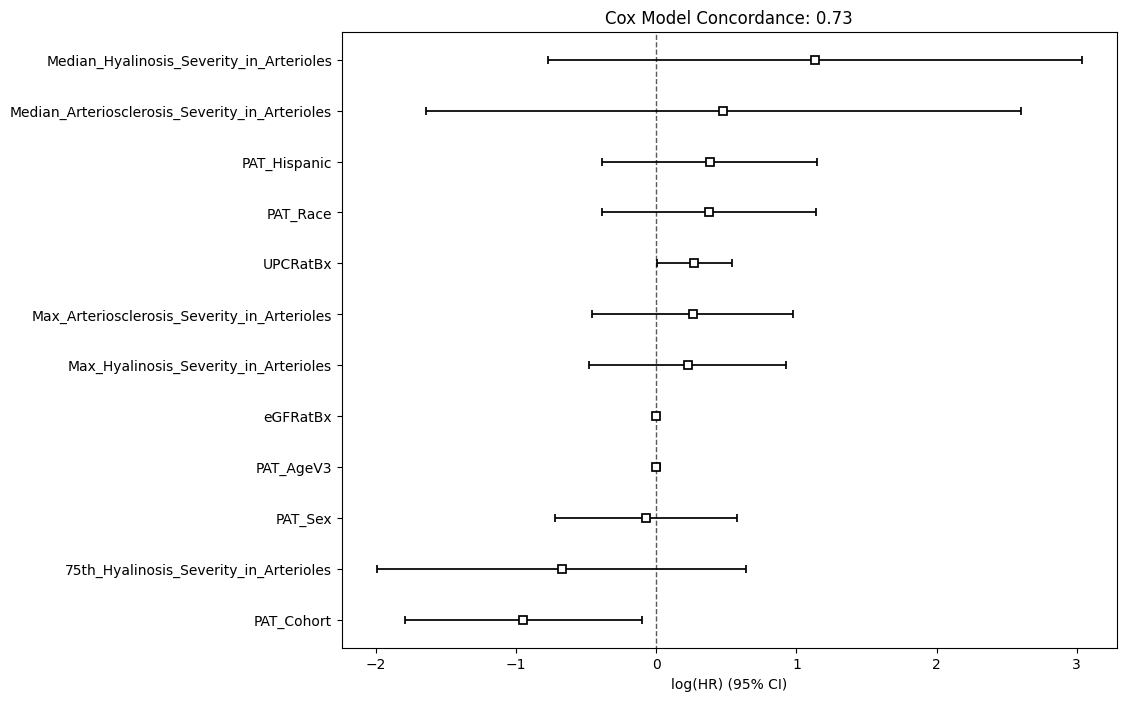

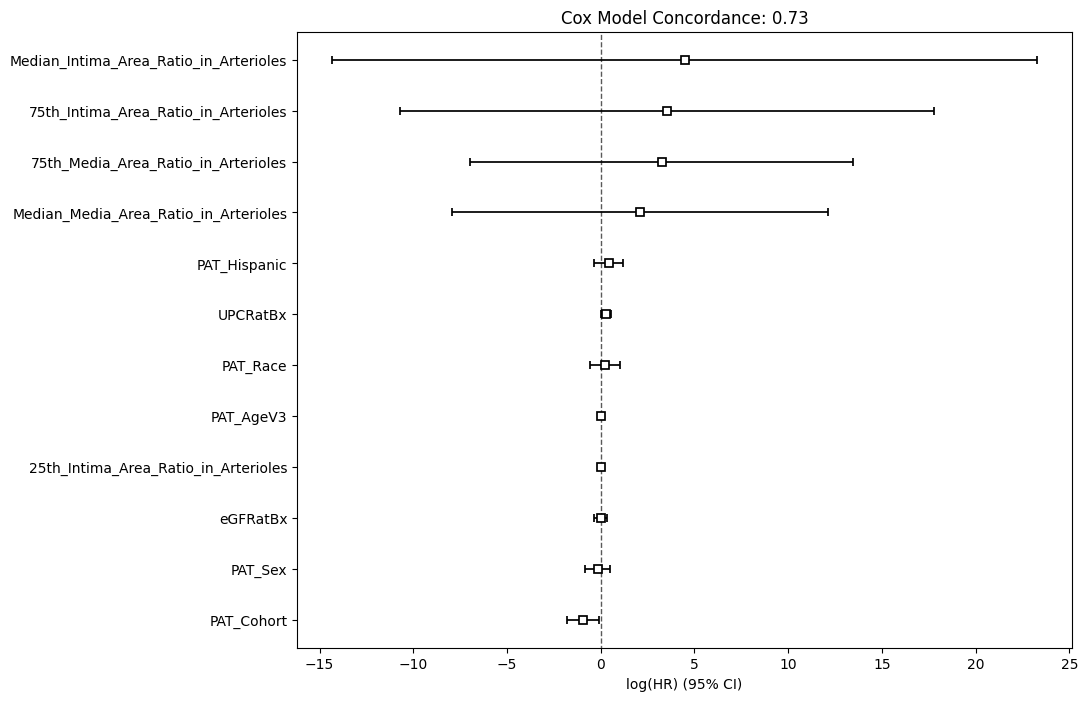

In [16]:
agged_features = agged_features_by_type["Arterioles"]
score_features = agged_scores_by_type["Arterioles"]
pat_df_selected = pat_df.dropna(subset = DEMOGRAPHICS + CLININCAL_DATA + DESCRIPTOR + agged_features, inplace = False)
print(pat_df_selected.shape)
# for feature in agged_features:
#     fig, axs = plt.subplots(1, 1, figsize=(8, 5))
#     survival_analysis(pat_df_selected, feature, .5, axs, c="") 
#     plt.tight_layout()
#     plt.show()
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , [])
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , DESCRIPTOR)
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , score_features)
cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , agged_features)
# cox_model_analysis(pat_df_selected, DEMOGRAPHICS + CLININCAL_DATA , score_features + agged_features)